In [189]:
from scipy import signal
from random import *
from matplotlib import pyplot as plt
import numpy as np

# sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
# sig_noise = sig + np.random.randn(len(sig))
# print(sig.shape, sig_noise)
# corr = signal.correlate(sig_noise, np.ones(128), mode='same', method='fft')/128

In [190]:
# the class name we want to model
model_class_names = [1,3]
# model_class_names = [3,6]

# number of centroids
num_centroids = 3

demo_light_percentage = 0.05;

# sample sample_time_index_num time-indexes/columns from the data (1024 columns totally)
sample_time_index_num = 1024;

lightcurve_train_set_path = "./StarLightCurves/StarLightCurves_TRAIN"
# lightcurve_train_set_path = "./MALLAT/MALLAT_TRAIN"

In [191]:
# sample_time_index_num time indexes from 1024 indexes
times_indexes = np.asarray(sorted(sample(list(range(0, 1024)), sample_time_index_num)))
# times_indexes = np.arange(0,1024, 1024/sample_time_index_num, dtype=int);
print("We choose the following ",sample_time_index_num, "time indexes from 1024 ones\n")

We choose the following  1024 time indexes from 1024 ones



In [192]:
# class name {1,2,3}
class_names = np.loadtxt(lightcurve_train_set_path, delimiter=',', usecols=[0])

# light curve data
light_curve = np.loadtxt(lightcurve_train_set_path, delimiter=',', usecols=range(1, 1025))

# normalize magnitude
light_curve -= light_curve.mean(1)[:,np.newaxis]
light_curve /= light_curve.std(1)[:,np.newaxis]


In [193]:
indices = [i for i,cn in enumerate(class_names) if cn in model_class_names]
print("model_class_names=",model_class_names," totally has ", len(indices), " rows");

demo_light_num = int(demo_light_percentage * len(indices))
indices = sorted(sample(indices, demo_light_num))
# indices = indices[0:demo_light_num]
print("We select the following ",len(indices)," rows\n")

model_class_names= [1, 3]  totally has  725  rows
We select the following  36  rows



In [194]:
light_series_set = light_curve[indices][:,times_indexes]
print(light_series_set.shape)

(36, 1024)


In [195]:
def calSumConvergeDis(timeseries_set, cluster, centroids):
    sum_r = 0;
    for i in range(len(timeseries_set)):
        j = int(cluster[i])
#         print(j, timeseries_set[i])
        corr = np.sum(signal.correlate(timeseries_set[i], centroids[j], mode='same', method='fft')/ len(timeseries_set[i]))
        sum_r = sum_r + corr ** 2 * 0.5
#     print(sum_r)
    return sum_r

In [196]:
def calDistance(timeseries_set, centroids):
    maxcorr = np.ones(len(timeseries_set)) * -9999
    best_centroids = np.ones(len(timeseries_set)) * -1
    
    for i in range(len(timeseries_set)):
        best_center = -1
        for j in range(len(centroids)):
            corr = np.sum(signal.correlate(timeseries_set[i], centroids[j], mode='same', method='fft')/ len(timeseries_set[i]))
            if maxcorr[i] < corr:
                maxcorr[i] = corr
                best_center = j
        best_centroids[i] = best_center
    
#     print(best_centroids)
    return best_centroids

In [197]:
def initCentroids(timeseries_set,num_centroids):
    random_indexes = sample(list(range(len(timeseries_set))), num_centroids)
    print("We initialize the centorids by indexes:", random_indexes)
    
#     rand_centroids = np.random.rand(num_centroids,sample_time_index_num)
#     print("initial_centroids\n",rand_centroids)
    return timeseries_set[random_indexes]

In [198]:
def recalCentroids(timeseries_set, cluster, centroids):
    new_centroids = np.array(centroids)
    for c in range(len(centroids)):
        if len(timeseries_set[cluster==c]) <= 0:
            new_centroids[c] = centroids[c];
        else:
            new_centroids[c] = np.mean(timeseries_set[cluster==c], axis=0)
        
    return new_centroids

In [199]:
centroids = initCentroids(light_series_set,num_centroids)
cluster = np.ones(len(light_series_set)) * -1
E_wc = 0
converge_iter_up = 50
up_iteration = 5000
r = 0

while r < converge_iter_up and up_iteration>0:
    cluster = calDistance(light_series_set,centroids)
    centroids = recalCentroids(light_series_set, cluster, centroids)

    E_wc_temp = calSumConvergeDis(light_series_set, cluster, centroids)
    
    if E_wc_temp > E_wc:
        r = 0
        E_wc = E_wc_temp

    r = r+1
    up_iteration=up_iteration-1
    
    
print(centroids, "\n", cluster)
centroids_file_name='./StarLight_files/pcad_save_files/model_save'+str(model_class_names)+str(demo_light_percentage)+'.npy'
# centroids_file_name='./MALLAT_files/pcad_save_files/model_save'+str(model_class_names)+str(demo_light_percentage)+'.npy'
np.save(centroids_file_name, centroids)



We initialize the centorids by indexes: [9, 3, 31]
[[ 0.59798966  0.60309213  0.60739421 ...,  0.7947849   0.76587091
   0.73455575]
 [ 0.55464554  0.55633247  0.55810837 ...,  0.55022668  0.54997379
   0.54934571]
 [ 0.61940627  0.6172052   0.61560441 ...,  0.68473826  0.69314238
   0.70204674]] 
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [200]:
r_centroids = initCentroids(light_series_set,num_centroids)
print(r_centroids)
r_centroids_file_name='./StarLight_files/pcad_save_files/model_save_r'+str(model_class_names)+str(demo_light_percentage)+'.npy'
# r_centroids_file_name='./MALLAT_files/pcad_save_files/model_save_r'+str(model_class_names)+str(demo_light_percentage)+'.npy'
np.save(r_centroids_file_name, r_centroids)

We initialize the centorids by indexes: [8, 11, 18]
[[ 0.65661881  0.65171643  0.64791459 ...,  0.67882959  0.65942017
   0.63840997]
 [ 0.76367297  0.7655739   0.76777497 ...,  0.78868517  0.7864841
   0.78358268]
 [ 0.71314669  0.71484752  0.7162482  ...,  0.63570909  0.64491356
   0.65431813]]


In [187]:
# save_file_path_1 = "./PCAD_files/centroids_" + str(model_class_names) + ".npy"
# np.save(save_file_path_1, centroids)

# save_file_path_2 = "./PCAD_files/cluster_" + str(model_class_names) + ".npy"
# np.save(save_file_path_2, cluster)

In [188]:
# class_names_test = np.loadtxt(lightcurve_test_set_path, delimiter=',', usecols=[0])

# light_curve_test = np.loadtxt(lightcurve_test_set_path, delimiter=',', usecols=range(1, 1025))
# light_curve_test -= light_curve_test.mean(1)[:,np.newaxis]
# light_curve_test /= light_curve_test.std(1)[:,np.newaxis]

# test_indices = [i for i,cn in enumerate(class_names_test) if cn == model_class_name]


In [25]:
# score = np.ones(len(test_indices))
# score = score.reshape(-1,1)

# n = len(light_series_set)
# for index in range(len(test_indices)):
#     for j in range(len(centroids)):
#         c_j_len = len(cluster[cluster==j])
#         corr = np.sum(signal.correlate(light_curve_test[index], centroids[j], mode='same', method='fft')/ len(light_curve_test[index]))
#         score[index] = score[index] + (c_j_len / n) * corr ** 2

In [26]:
# test_indices = np.asarray(test_indices)
# test_indices = test_indices.reshape(-1,1)

In [27]:
# combine_result = np.concatenate((test_indices, score), axis=1)
# sorted_result = np.sort(combine_result.view('i8,i8'), order=['f1'], axis=0).view(np.float)
# print(sorted_result)

[[  6.60300000e+03   1.06047063e+00]
 [  3.75300000e+03   1.09754700e+00]
 [  6.24400000e+03   1.10263301e+00]
 ..., 
 [  1.44200000e+03   2.22629160e+02]
 [  1.64200000e+03   2.81994479e+02]
 [  7.26100000e+03   2.87474760e+02]]


In [28]:
result_file_name = "pacd_sorted" + str(model_class_name) + ".csv";
np.savetxt(result_file_name, sorted_result, delimiter=",",fmt='%d,%1.9f')

In [29]:
test_sort_top_indices = sorted_result[:10:][:,0]
print(test_sort_top_indices)

[ 6603.  3753.  6244.  2753.  7797.  5150.  5397.  5040.  3033.  1264.]


In [30]:
from scipy.interpolate import interp1d
def plot_test(sort_indeies, type):
    plt.figure(figsize=(18,1.85))

    # X_r = np.arange(1,1025)
    # Y_r = light_curve_test[test_indices[0],:]

    # print(X_r.shape, Y_r.shape)

    for index, item in enumerate(sort_indeies):

        X_r = np.arange(1,1025)
        Y_r = light_curve_test[int(item),:]

        smooth_func = interp1d(X_r, Y_r, kind='cubic')
        Xnew = np.linspace(X_r.min(), X_r.max(), num=sample_time_index_num, endpoint=True)
        plt.subplot(1, 11, index+2)
        plt.plot(X_r, Y_r, 'kx', mew=2)
        plt.plot(Xnew, smooth_func(Xnew), '-')
        plt.xlabel('star %i'%item)
        
    plt.show()
    
#     GPy.plotting.matplot_dep.base_plots.align_subplots(1,11, xlim=(1,1000), ylim=(-3,3))
#     fig_name = "model_class_name_" + str(model_class_name) + "_" + type;
#     plt.savefig(fig_name);

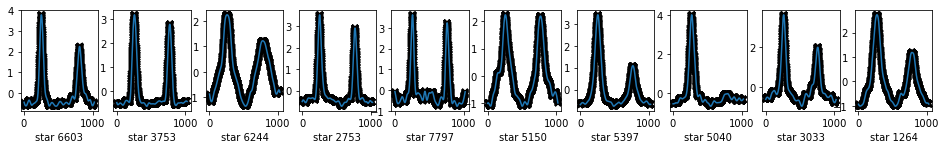

In [31]:
# top- small - anomaly
plot_test(test_sort_top_indices, "top")

In [32]:
test_sort_last_indices = sorted_result[-10:][:,0]
print(test_sort_last_indices)

[ 6569.  1504.  5313.  2065.  7461.  3939.  7358.  1442.  1642.  7261.]


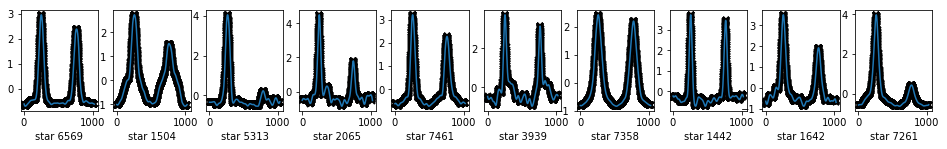

In [33]:
plot_test(test_sort_last_indices, "last")